In [1]:
%matplotlib qt
import tensorflow as tf

from tensorflow.keras.layers import Layer, Dense, Dropout, BatchNormalization, LayerNormalization, Lambda, Input
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np

import gymnasium as gym

import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

2023-06-05 08:11:14.506638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 08:11:24.728784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2023-06-05 08:11:51.295637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]

# Objective: Create a DDPG algorithm with a GPT as the Actor network.   

In [3]:
#Ornstein-Uhlenbeck Noise 
class OUActionNoise(object):
    def __init__(self, mean, sigma=0.5, theta=0.2, dt=0.4, x0=None):
        self.mean = mean
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.x0 = x0
        self.reset()
    
    #--------------------------------------------------------------------------------
    #Method that enables to write classes where the instances behave like functions and can be called like a function.    
    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        self.x_prev = x
        
        return x
    
    #--------------------------------------------------------------------------------
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mean)
        return

In [4]:
#Replay Buffer 
class ReplayBuffer(object):
    def __init__(self, size, batch_size):
        '''
        Args:
            size (integer): The size of the replay buffer.              
            batch_size (integer): The batch size.
            block_size (integer): 
        '''
        self.buffer = [[]]
        self.batch_size = batch_size
        self.max_size = size
        
    #--------------------------------------------------    
    def append(self, steps):
        # steps = [{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]
        if self.size >= self.max_size: del self.buffer[0]
        for step in steps: self.buffer[-1].append(step)
        # if done create new episode entry
        # (state, action, reward, done)
        if (steps[-1]['done']): self.buffer.append([])

    #--------------------------------------------------
    def clear(self):
        self.buffer.clear()
    
    #--------------------------------------------------    
    def getEpisodes(self):
        episodes = np.random.choice(
            np.arange(self.size - 1), #don't chose the current step
            size=(self.batch_size,), 
            replace=True
        )
        return  [self.buffer[episode] for episode in episodes]
    
    #--------------------------------------------------  
    @property  
    def size(self):
        '''
        Returns:
            Number of elements in the buffer
        '''
        return len(self.buffer)

    #--------------------------------------------------  
    @property 
    def hasMinLength(self):
        '''
        Returns:
            Boolean indicating if the memory have the minimum number of elements or not
        '''
        return (self.size > 8)
    
    #--------------------------------------------------
    @property  
    def data(self):
        '''
        Returns:
            List with all the elements in the buffer
        '''
        return self.buffer

In [5]:
gpt_kernel_initializer = lambda: RandomNormal(mean=0.0, stddev=0.2)
gpt_bias_initializer = lambda: Zeros()

In [6]:
# Individual Head of self-attention
class Head(Layer):
    """ one head of self-attention """
    def __init__(self, batch_size, block_size, head_size, dropout, op_type):
        super().__init__()
        self.batch_size = batch_size
        self.block_size = block_size
        self.op_type = op_type

        # key, query and value layers
        self.key = Dense(units=head_size, use_bias=False, kernel_initializer=gpt_kernel_initializer())
        self.query = Dense(units=head_size, use_bias=False, kernel_initializer=gpt_kernel_initializer())
        self.value = Dense(units=head_size, use_bias=False, kernel_initializer=gpt_kernel_initializer())

        # dropout layer
        self.dropout_v = Dropout(dropout)

    #--------------------------------------------------
    def call(self, inp, training=False):
        state_emb, global_pos_emb, action_emb = inp[0], inp[1], inp[2]
        B, T, C = state_emb.shape
        if(B is None): B = self.batch_size 
        if(T is None): T = self.block_size
        if(C is None): C = self.state_dim

        if(self.op_type == 0):
            k = self.key(global_pos_emb + state_emb)
            v = self.value(state_emb)
            wei =  tf.matmul(k, tf.transpose(k, perm=[0, 2, 1]))

        elif(self.op_type == 1):
            k = self.key(global_pos_emb + action_emb + state_emb)
            v = self.value(state_emb + action_emb)
            wei =  tf.matmul(k, tf.transpose(k, perm=[0, 2, 1]))

        elif(self.op_type == 2):
            k = self.key((global_pos_emb * action_emb) + state_emb)
            v = self.value(state_emb)
            wei =  tf.matmul(k, tf.transpose(k, perm=[0, 2, 1]))

        elif(self.op_type == 3):
            k = self.key(global_pos_emb + state_emb)
            v = self.value(global_pos_emb + state_emb)
            wei =  tf.matmul(k, tf.transpose(k, perm=[0, 2, 1]))
        
        else:
            k = self.key(global_pos_emb + state_emb)
            q = self.query(global_pos_emb + state_emb)
            v = self.value(global_pos_emb + state_emb)
            wei =  tf.matmul(q, tf.transpose(k, perm=[0, 2, 1]))

        wei *= tf.math.rsqrt(tf.cast(C, tf.float32))
        wei = tf.where(tf.linalg.band_part(tf.ones((T, T)), -1, 0) == 0, tf.constant(float("-inf"), shape=(B, T, T)), wei) # (B, T, T)
        wei = tf.nn.softmax(wei, axis=-1) # (B, T, T)
        # perform the weighted aggregation of the values

        out = tf.matmul(wei, v) # (B, T, T) @ (B, T, C) -> (B, T, C)
        out = self.dropout_v(out)

        return out
    
    #--------------------------------------------------
    def build(self, input_shape):
        #state_emb = global_pos_emb = local_pos_emb = embedding_dim
        state_emb, global_pos_emb, action_emb = input_shape
        self.value.build(state_emb)
        self.key.build(state_emb)
        self.query.build(state_emb)
        super(Head, self).build((len(input_shape), None, None, None))

In [7]:
# Layer with multiple self-attention Heads for data communication 
class MultiHeadAttention(Layer):
    """ multiple heads of self-attention in parallel """
    def __init__(self, batch_size, block_size, embedding_dim, num_heads, head_size, dropout, head_op_type):
        super().__init__()
        self.num_heads = num_heads
        self.heads = []
        for _ in range(num_heads):
            head = Head(
                batch_size=batch_size,
                block_size=block_size,
                head_size=head_size,
                dropout=dropout,
                op_type=head_op_type
            )
            head.build(((None, None, embedding_dim), (None, None, embedding_dim), (None, None, embedding_dim)))
            self.heads.append(head)
        
        # this linear layer is used to 'merge' the multiple heads acquired knowledge
        self.proj = Dense(units=embedding_dim, activation='relu', kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer())
        self.dropout = Dropout(dropout)

    #--------------------------------------------------
    def call(self, inp, training=False):
        # concatenate the heads outputs in the C dimension
        out =  tf.concat([h(inp) for h in self.heads], axis=-1)
        # apply thE projection and dropout
        out = self.dropout(self.proj(out))
        return out
    
    #--------------------------------------------------
    def build(self, input_shape):
        super(MultiHeadAttention, self).build((len(input_shape), None, None, None))

In [8]:
#Simple feed forward for data computation
class FeedForward(Layer):
    def __init__(self, embedding_dim, dropout, resize_to_input_dim=True, spread_dim=None):
        # resize_to_input_dim -> Should be False only to last block element when posterior computation is gonna happen so it doesn't need to output embedding_dim sized elements to another block
        # spread_dim -> the heads output comes concatenated in sequence so is computed and joint by the spread layer layer
        super().__init__()
        last_layer = [
            Dense(embedding_dim, activation='relu', kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer()), 
            Dropout(dropout)
        ] if resize_to_input_dim else []
        
        self.net = Sequential([
            Dense(spread_dim if spread_dim is not None else 4 * embedding_dim, activation='relu', kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer()),
            Dropout(dropout),
            *last_layer
        ])

    #--------------------------------------------------
    def call(self, x):
        return self.net(x)

In [9]:
# Block containing a multi head attention module and a feed forward linear computation
class Block(Layer):
    """ Transformer block: communication followed by computation """
    def __init__(self, batch_size, block_size, emb_dim, num_heads, dropout, head_op_type, resize_to_input_dim=None, spread_dim=None):
        super().__init__()
        self.resize_to_input_dim = resize_to_input_dim
        head_size = emb_dim // num_heads # each head gets a portion of the embeddings so different relations can be learned
        
        self.sa = MultiHeadAttention(batch_size, block_size, emb_dim, num_heads, head_size, dropout, head_op_type)

        self.ffwd = FeedForward(emb_dim, dropout, resize_to_input_dim, spread_dim)
        self.ffwd_ln = BatchNormalization()

    #--------------------------------------------------
    def call(self, inp, training=False):
        st_emp, global_pos_emb, act_emb = inp[0], inp[1], inp[2]

        # Multi head attention with layer norm
        x = st_emp + self.sa([st_emp, global_pos_emb, act_emb])
        
        # feed forward with layer norm
        ffw = self.ffwd(self.ffwd_ln(x))
        x = (x + ffw) if self.resize_to_input_dim else ffw

        return x
    
    #--------------------------------------------------
    def build(self, input_shape):
        st_emb, global_pos_emb, act_emb = input_shape
        self.ffwd_ln.build(st_emb)
        self.sa.build(input_shape)
        super(Block, self).build((len(input_shape), None, None, None))

In [10]:
f_value = lambda : RandomNormal(mean=0.0, stddev=0.1)

In [11]:
class GPTModel(Model):
    def __init__(self, n_layer, batch_size, block_size, embedding_dim, out_dim, num_heads, dropout, ffw, head_op_type):
        super().__init__()
        self.block_size = block_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim

        self.state_embedding = Dense(units=embedding_dim, kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer())
        self.action_embedding = Dense(units=embedding_dim, kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer())
        self.position_embedding = Dense(units=embedding_dim, kernel_initializer=gpt_kernel_initializer(), bias_initializer=gpt_bias_initializer())
        
        self.blocks = []
        for i in range(n_layer):
            block = Block(batch_size, block_size, embedding_dim, num_heads, dropout, head_op_type,
                resize_to_input_dim = (i != n_layer - 1 ),  
                spread_dim = out_dim if (i == n_layer - 1 ) else None,
            )
            block.build(((None, None, embedding_dim), (None, None, embedding_dim), (None, None, embedding_dim)))
            self.blocks.append(block)

        self.ffw = ffw

    #--------------------------------------------------
    def get_local_position_sin_encoding(self, batch_size, block_size, n=10000):
        positions = np.tile([np.arange(block_size)], [batch_size, 1])
        batch_size, block_size = positions.shape[:2]
        aux = np.tile(np.tile([np.arange(self.embedding_dim)], [block_size, 1]), [batch_size, 1, 1])
        denominator = tf.cast(n**((2*(aux//2))/self.embedding_dim), dtype=tf.float32)
        val = tf.cast(np.tile(positions, [1, 1, self.embedding_dim]), dtype=tf.float32)
        P = (np.sin(val/denominator) * ((aux + 1)%2)) + (np.cos(val/denominator)*(aux%2))
        return P
  
    #--------------------------------------------------
    def call(self, inp, training=False):
        states, global_positions, actions = inp[0], inp[1], inp[2]
        B, T, C = states.shape
        if(T is None): T = self.block_size
        if(B is None): B = self.batch_size

        #local_position = self.get_local_position_sin_encoding(batch_size=B, block_size=T)
        act_emb = self.action_embedding(actions)
        st_emb = self.state_embedding(states)
        pos_emb = self.position_embedding(global_positions)
        
        for block in self.blocks: st_emb = block((st_emb, pos_emb, act_emb))
        logits = self.ffw(st_emb)

        return logits
    
    #--------------------------------------------------
    def generate(self, states, positions, actions):
        # crop idx to the last block_size tokens
        st_cond = states[:, -self.block_size:, :]
        pos_cond = positions[:, -self.block_size:, :]
        act_cond = actions[:, -self.block_size:, :]
        # get the predictions
        actions = self([st_cond, pos_cond, act_cond])
        # focus only on the last time step
        return actions
    
    #--------------------------------------------------
    def build(self, input_shape):
        states, positions, actions = input_shape
        self.action_embedding.build(actions)
        self.state_embedding.build(states)
        self.position_embedding.build(positions)
        super(GPTModel, self).build((len(input_shape), None, None, None))

In [12]:
class Actor(object):
    def __init__(self, n_layer, batch_size, block_size, state_dim, action_dim, embedding_dim, num_heads, dropout, action_range, lr, head_op_type):
        #Network dimensions
        self.inp_dim = state_dim
        self.action_dim = action_dim

        last_block_dim = 512
        inp_layer = Input((None, last_block_dim))
        inp = Dropout(dropout)(inp_layer)
        inp = BatchNormalization()(inp)

        act_net = Dense(128, activation='relu', kernel_initializer=f_value(), bias_initializer=f_value())(inp)
        act_net = Dropout(dropout)(act_net)
        act_net = BatchNormalization()(act_net)
        act_net = Dense(16, activation='relu', kernel_initializer=f_value(), bias_initializer=f_value())(act_net)
        act_net = Dropout(dropout)(act_net)
        act_net = BatchNormalization()(act_net)
        act_net = Dense(action_dim, activation='tanh', kernel_initializer=f_value(), bias_initializer=f_value())(act_net)
        act_net = Lambda(lambda i: i * action_range, dtype='float64')(act_net)
 
        st_net = Dense(64, activation='relu', kernel_initializer=f_value(), bias_initializer=f_value())(inp)
        st_net = Dropout(dropout)(st_net)
        st_net = BatchNormalization()(st_net)
        st_net = Dense(state_dim, activation='linear', kernel_initializer=f_value(), bias_initializer=f_value())(st_net)

        #Generates the optimization function - used in the agent to generate gradients
        self.optimizer = Adam(lr)

        #Generates the actor model
        self.model = GPTModel(
            n_layer=n_layer,
            batch_size=batch_size, 
            block_size=block_size, 
            embedding_dim=embedding_dim, 
            out_dim=last_block_dim,
            num_heads=num_heads,
            dropout=dropout,
            ffw = Model(inp_layer, [st_net, act_net]),
            head_op_type=head_op_type,
        )
        self.model.build(((None, None, state_dim), (None, None, embedding_dim), (None, None, action_dim)))

    #--------------------------------------------------------------------
    def predict(self, states, positions, actions):
        return self.model.generate(states, positions, actions)
    
    #--------------------------------------------------------------------
    def act(self, states, positions, actions):
        _, action = self.predict(states, positions, actions)
        # Gets the last action only
        action = action[0, -1, :]
        return action
        
    #--------------------------------------------------------------------
    def saveModel(self, path):
        self.model.save(path + '_actor_model.h5')
    
    #--------------------------------------------------------------------
    def loadModel(self, path):
        self.model = load_model(path)

In [13]:
class Critic(object):
    def __init__(self, n_layer, batch_size, block_size, state_dim, action_dim, embedding_dim, out_dim, num_heads, dropout, lr, head_op_type):
        #Network dimensions
        self.inp_dim = state_dim + action_dim
        ffw = lambda: Sequential([
                Dense(128, activation='relu', kernel_initializer=f_value(), bias_initializer=f_value()),
                Dropout(dropout),
                BatchNormalization(),
                Dense(32, activation='relu', kernel_initializer=f_value(), bias_initializer=f_value()),
                Dropout(dropout),
                BatchNormalization(),
                Dense(out_dim, activation='linear', kernel_initializer=f_value(), bias_initializer=f_value()),
            ]) 

        #Generates the optimization function - used in the agent to generate gradients
        self.optimizer = Adam(lr)

        #Generates the actor model
        self.model = GPTModel(
            n_layer=n_layer,
            batch_size=batch_size, 
            block_size=block_size, 
            embedding_dim=embedding_dim, 
            out_dim=256,
            num_heads=num_heads,
            dropout=dropout,
            ffw = ffw(),
            head_op_type=head_op_type,
        )
        self.model.build(((None, None, self.inp_dim), (None, None, embedding_dim), (None, None, action_dim)))
    
    #--------------------------------------------------------------------
    def predict(self, states, next_actions, positions, actions):
        states = tf.cast(states, tf.float32) 
        next_actions = tf.cast(next_actions, tf.float32) 
        positions = tf.cast(positions, tf.float32)
        actions = tf.cast(actions, tf.float32)
        inp = tf.concat([states, next_actions], 2)
        return self.model.generate(inp, positions, actions)
        
    #--------------------------------------------------------------------
    def saveModel(self, path):
        self.model.save(path + '_critic_model.h5', save_format="tf")
    
    #--------------------------------------------------------------------
    def loadModel(self, path):
        self.model = load_model(path)

In [14]:
class DDPG_GPT_Agent(object):
    def __init__(self, a_n_layers, c_n_layers, batch_size, block_size, state_dim, action_dim, a_n_heads, c_n_heads, 
        dropout, action_min, action_max, memory_size, gamma, a_lr, c_lr, epsilon, epsilon_decay, 
        epsilon_min, a_embedding_dim, c_embedding_dim, a_head_op_type, c_head_op_type):
        
        self.block_size = block_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_min = action_min
        self.action_max = action_max
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.a_embedding_dim = a_embedding_dim
        self.c_embedding_dim = c_embedding_dim

        self.episode_batch_size = batch_size
        self.steps_batch_size = 1

        #Creates the Replay Buffer
        self.memory = ReplayBuffer(memory_size, self.episode_batch_size)

        #Creates the noise generator
        self.ou_noise = OUActionNoise(mean=np.zeros(action_dim))

        #Creates the actor
        self.actor = Actor(
            n_layer=a_n_layers,
            batch_size=batch_size, 
            block_size=block_size, 
            state_dim=state_dim, 
            action_dim=action_dim, 
            embedding_dim=a_embedding_dim,
            num_heads=a_n_heads, 
            dropout=dropout, 
            action_range=action_max, 
            lr=a_lr, 
            head_op_type=a_head_op_type
        )
        
        #Creates the critic
        self.critic = Critic(
            n_layer=c_n_layers,
            batch_size=batch_size, 
            block_size=block_size, 
            state_dim=state_dim, 
            action_dim=action_dim, 
            embedding_dim=c_embedding_dim,
            out_dim=1,
            num_heads=c_n_heads, 
            dropout=dropout, 
            lr=c_lr, 
            head_op_type=c_head_op_type
        )

        self.ct_loss = []
        self.ac_loss_rw = []
        self.ac_loss_st = []
        self.scores_history = []
        self.steps_history = []
        self.ac_loss_final = []

        plt.ion()
        self.fig = plt.figure()
        self.ac_loss_rw_plot = self.fig.add_subplot(221)
        self.ac_loss_rw_plot.title.set_text('Actor return loss')

        self.ac_loss_st_plot = self.fig.add_subplot(222)
        self.ac_loss_st_plot.title.set_text('Actor state loss')

        self.ac_loss_final_plot = self.fig.add_subplot(223)
        self.ac_loss_final_plot.title.set_text('Actor final loss')

        self.ct_loss_plot = self.fig.add_subplot(224)
        self.ct_loss_plot.title.set_text('Critic loss')
    
    #--------------------------------------------------------------------     
    def act(self, env):
        action = np.zeros(self.action_dim)
        state, _ = env.reset()
        step = np.array([1])

        actions = action.reshape(1, 1, -1)
        states = state.reshape(1, 1, -1)
        positions = step.reshape(1, 1, -1)

        done = False
        while not done:
            env.render()
            action = self.policy(states, positions, actions, explore=False)
            state, reward, done, term, info = env.step(action)
            step += 1

            states = tf.concat((states, state.reshape(1, 1, -1)), axis=1)
            positions = tf.concat((positions, np.array([step]).reshape(1, 1, -1)), axis=1)
            actions = tf.concat((actions, action.reshape(1, 1, -1)), axis=1)
        
        return
    
    #-------------------------------------------------------------------- 
    def get_position_sin_encoding(self, embedding_dim, positions, n=10000):
        batch_size, block_size = positions.shape[:2]
        aux = np.tile(np.tile([np.arange(embedding_dim)], [block_size, 1]), [batch_size, 1, 1])
        denominator = tf.cast(n**((2*(aux//2))/embedding_dim), dtype=tf.float32)
        val = tf.cast(np.tile(positions, [1, 1, embedding_dim]), dtype=tf.float32)
        P = (np.sin(val/denominator) * ((aux + 1)%2)) + (np.cos(val/denominator)*(aux%2))
        return P

    #-------------------------------------------------------------------- 
    def policy(self, states, positions, actions, explore=True):
        """ Generates an action from a group of states and add exploration """
        # gets the action
        action = self.actor.act(states, self.get_position_sin_encoding(self.a_embedding_dim, positions), actions)
        # takes the exploration with the epsilon probability
        if explore and np.random.rand() < self.epsilon: action += self.ou_noise()
        # clip the action to be between min and max values
        action = np.clip(action, a_min=self.action_min, a_max=self.action_max)
        action[np.isnan(action)] = 0

        return action   
    
    #--------------------------------------------------------------------
    def record_memories(self, steps):
        # steps = [{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]
        self.memory.append(steps)
        return
    
    #--------------------------------------------------------------------
    def learn(self, memory_steps):
        # steps = [{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]
        """ Append an experience to the memory and replay memory if possible """
        self.record_memories(memory_steps)
        if self.memory.hasMinLength: self.replay_memory()
        return
    
    #--------------------------------------------------
    def episode_to_batch(self, episode):
        #episode = [{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]
        if len(episode) > (self.block_size + self.steps_batch_size):
            steps_idxs = np.random.choice(np.arange(self.block_size, len(episode)+1), size=self.steps_batch_size, replace=False)
        else: steps_idxs = np.arange(self.block_size, len(episode))
        
        batch = np.array([episode[i-self.block_size:i] for i in steps_idxs])
        #batch = [[{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]]
        return batch

    #--------------------------------------------------
    def null_step(self, step):
        #step = {'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}
        step['reward'] = 0
        step['done'] = 1
        return step

    #--------------------------------------------------
    def episode_pad(self, episode):
        #episode = [{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]
        return np.concatenate((episode, [self.null_step(episode[-1]) for _ in range(self.block_size - len(episode) + 1)]))
    
    #--------------------------------------------------
    def get_episodes_batches(self, episodes):
        #episodes = [[{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]]
        batch = None

        join_episode = lambda final_value, aux_value: aux_value if final_value is None else np.concatenate((final_value, aux_value))

        for episode in episodes:
            if len(episode) <= self.block_size: episode = self.episode_pad(episode)
            ep_batch = self.episode_to_batch(episode)
            batch = join_episode(batch, ep_batch)

        return batch

    #--------------------------------------------------------------------    
    def replay_memory(self):
        """ Replay a batch of memories """

        # Get sample block from the replay buffer
        episodes = self.memory.getEpisodes()
        batch = self.get_episodes_batches(episodes)
        #batch = [[{'step': int, 'prev_action': [action_dim], 'state': [state_dim], 'action':  [action_dim], 'next_state': [state_dim], 'reward': float, 'done': boolean}]]
        to_tensor = lambda value: tf.convert_to_tensor(value, dtype='float32')
        get_batch_element = lambda key, batch: to_tensor([[step[key] for step in block] for block in batch])
        
        positions = tf.expand_dims(get_batch_element('step', batch), axis=-1)
        next_positions_actor = self.get_position_sin_encoding(self.a_embedding_dim, positions + 1)
        next_positions_critic = self.get_position_sin_encoding(self.c_embedding_dim, positions + 1)
        positions_actor = self.get_position_sin_encoding(self.a_embedding_dim, positions)
        positions_critic = self.get_position_sin_encoding(self.c_embedding_dim, positions)

        states = get_batch_element('state', batch)
        next_states = get_batch_element('next_state', batch)

        prev_actions = get_batch_element('prev_action', batch)  
        actions = get_batch_element('action', batch)

        rewards = tf.expand_dims(get_batch_element('reward', batch), axis=-1)
        done = tf.expand_dims(get_batch_element('done', batch), axis=-1)

        #Train the critic
        with tf.GradientTape() as tape:
            # Compute the actor target actions
            _, target_actions = self.actor.predict(next_states, next_positions_actor, actions)
            # Compute the critic target values 
            predicted_return = self.critic.predict(next_states, target_actions, next_positions_critic, actions)
            # The return for the last block element
            last_return = predicted_return[:, -1, :]

            # Compute the gamma tensor based on the block step
            gamma_values = lambda i: tf.expand_dims(tf.repeat([[self.gamma**(k - i+1) for k in range(i, rewards.shape[1]-1)]], repeats=rewards.shape[0], axis=0), axis=-1)
            # Compute the gamma weighted reward for a given block step
            weighted_next_rewards = lambda i: tf.math.reduce_sum(rewards[:, i+1:, :] * gamma_values(i), axis=1)
            # The gamma weight for the last return bootstrap
            last_return_weight = lambda i: self.gamma ** (rewards.shape[1] - i)
            # Compute the done value for a block step
            state_done = lambda i: 1 - done[:, i, :]
            
            # Compute the return target values
            computed_returns = tf.stack([
                *[((weighted_next_rewards(i) + (last_return_weight(i) * last_return * state_done(-1))) * state_done(i)) for i in range(rewards.shape[1]-1)], 
                tf.zeros([rewards.shape[0], 1]),
            ], axis=1)
            #bootstrapped_returns = self.gamma * predicted_return * (1 - done)
            
            y = rewards + computed_returns
            # Predict the expected reward associated with taking the target predicted action in the state
            critic_value = self.critic.predict(states, actions, positions_critic, prev_actions)
            # Compute the critic loss  
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, self.critic.model.trainable_variables)
        self.critic.optimizer.apply_gradients(
            (grad, var) 
            for (grad, var) in zip(critic_grad, self.critic.model.trainable_variables) 
            if grad is not None
        )
        self.ct_loss.append(critic_loss)
        
        #Train the actor
        with tf.GradientTape() as tape:
            next_st, acts = self.actor.predict(states, positions_actor, prev_actions)
            critic_grads = self.critic.predict(states, acts, positions_critic, prev_actions)
            #Used -mean as we want to maximize the value given by the critic for our actions
            return_loss = -tf.math.reduce_mean(critic_grads)
            state_loss = tf.math.reduce_mean(tf.math.square(next_states - next_st))
            actor_loss = return_loss + state_loss

        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor.optimizer.apply_gradients(
            (grad, var) 
            for (grad, var) in zip(actor_grad, self.actor.model.trainable_variables)
            if grad is not None
        )
        self.ac_loss_rw.append(return_loss)
        self.ac_loss_st.append(state_loss)
        self.ac_loss_final.append(actor_loss)

        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)
        
        return
    #--------------------------------------------------
    def update_plots(self):
        self.ac_loss_rw_plot.plot(np.arange(len(self.ac_loss_rw)), self.ac_loss_rw,'r-')
        self.ac_loss_st_plot.plot(np.arange(len(self.ac_loss_st)), self.ac_loss_st,  'r-')
        self.ac_loss_final_plot.plot(np.arange(len(self.ac_loss_final)), self.ac_loss_final,  'r-')
        self.ct_loss_plot.plot(np.arange(len(self.ct_loss)), self.ct_loss,  'r-')

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        return

    #--------------------------------------------------
    def print_data(self, verbose, episode, step, score):
        if verbose:
            print("\r                                                          ", end="")
            print("\rEpisode: "+str(episode+1)+"\t Step: "+str(step)+"\tReward: "+str(round(score, 2)) ,end="")
        return

    #--------------------------------------------------------------------     
    def train(self, env, num_episodes, step_per_train, verbose, verbose_num, end_on_complete=False, complete_num=1, complete_value=float('inf'), act_after_batch=False):
        self.scores_history = []
        self.steps_history = []
        complete = 0
        self.ct_loss = []
        self.ac_loss = []
        print("BEGIN\n")
        
        for episode in range(num_episodes):
            done = False
            score, step = 0, 1
            state, _ = env.reset()
            prev_action = np.zeros(self.action_dim)

            states = state.reshape(1, 1, -1)
            positions = np.array([step]).reshape(1, 1, -1)
            actions = prev_action.reshape(1, 1, -1)
            
            while not done:
                memory_steps = []

                for _ in range(step_per_train):
                    action = self.policy(states, positions, actions)
                    new_state, reward, done, term, info = env.step(action)
                    self.print_data(verbose, episode, step, score)
                    
                    memory_steps.append({
                        'step': step, 
                        'prev_action': prev_action, 
                        'state': state, 
                        'action':  action, 
                        'next_state': new_state, 
                        'reward': reward, 
                        'done':  int(done),
                    })

                    state = new_state
                    prev_action = action
                    step += 1
                    score += reward

                    states = tf.concat((states, new_state.reshape(1, 1, -1)), axis=1)
                    positions = tf.concat((positions, np.array([step]).reshape(1, 1, -1)), axis=1)
                    actions = tf.concat((actions, action.reshape(1, 1, -1)), axis=1)
                    if done: break
                
                if len(memory_steps) > 0: self.learn(memory_steps)

            self.scores_history.append(score)
            self.steps_history.append(step)

            self.update_plots()
            
            #If the score is bigger or equal than the complete score it add one to the completed number
            if(score >= complete_value):
                complete += 1
                #If the flag is true the agent ends the trainig on the firs complete episode
                if end_on_complete and complete >= complete_num: break
            
            #These information are printed after each verbose_num episodes
            if((episode+1)%verbose_num == 0):
                print("\r                                                                                                                         ", end="")
                print("\rEpisodes: ", episode+1, "/", num_episodes, 
                      "\n\tTotal reward: ", round(np.mean(self.scores_history[-verbose_num:]), 2), '+/-', round(np.std(self.scores_history[-verbose_num:]), 2), 
                      "\n\tNum. steps: ", round(np.mean(self.steps_history[-verbose_num:]), 2), '+/-', round(np.std(self.steps_history[-verbose_num:]), 2), 
                      *["\n\tCompleted: ", complete] if complete_value != float('inf') else '', 
                      "\n--------------------------",
                    )
                
                #If the flag is true the agent act and render the episode after each verbose_num episodes
                if act_after_batch: self.act(env)
                
                #Set the number of completed episodes on the batch to zero
                complete = 0

        print("\nFINISHED")
    #--------------------------------------------------------------------     
    def save(self, path):
        self.actor.saveModel(path)
        self.critic.saveModel(path)
    
    #--------------------------------------------------------------------
    def load(self, a_path, c_path):
        self.actor.loadModel(a_path)
        self.critic.loadModel(c_path)

In [15]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
batch_size = 256
block_size = 16
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_min = env.action_space.low
action_max = env.action_space.high
dropout = 0.05
memory_size = 200
gamma = 0.99

epsilon = 1
epsilon_decay = 0.9995
epsilon_min = 0.3

# Actor hyperparameter
a_n_layer = 2
a_num_heads = 2
a_embedding_dim = 20
a_learning_rate = 5e-5
a_head_op_type = 1

# Critic hyperparameter
c_n_layer = 1 
c_num_heads = 2
c_embedding_dim = 32
c_learning_rate = 3e-4
c_head_op_type = 1

agent = DDPG_GPT_Agent(
    a_n_layers = a_n_layer,
    c_n_layers = c_n_layer, 
    batch_size = batch_size, 
    block_size=block_size, 
    state_dim=state_dim, 
    action_dim=action_dim, 
    a_embedding_dim=a_embedding_dim,
    c_embedding_dim=c_embedding_dim,
    a_n_heads=a_num_heads, 
    c_n_heads=c_num_heads,
    dropout=dropout, 
    action_min=action_min, 
    action_max=action_max, 
    memory_size=memory_size, 
    gamma=gamma, 
    a_lr=a_learning_rate, 
    c_lr=c_learning_rate, 
    epsilon=epsilon, 
    epsilon_decay=epsilon_decay, 
    epsilon_min=epsilon_min,
    a_head_op_type=a_head_op_type,
    c_head_op_type=c_head_op_type,
)
print(
    '----------- Agent specs ----------------\n' +
    'Batch Size: ' + str(batch_size) + '\n' +
    'Block Size: ' + str(block_size) + '\n' +
    'Dropout: ' + str(dropout) + '\n' +
    'Memory Size: ' + str(memory_size) + '\n' +
    'Gamma: ' + str(gamma) + '\n' +
    'Epsilon: ' + str(epsilon) + '\n' +
    'Epsilon decay: ' + str(epsilon_decay) + '\n' +
    'Epsilon min: ' + str(epsilon_min) + '\n' +
    '----------- Actor specs -----------------\n' + 
    'Actor num layers: ' + str(a_n_layer) + '\n' +
    'Actor num heads: ' + str(a_num_heads) + '\n' +
    'Actor embedding dim: ' + str(a_embedding_dim) + '\n' +
    'Actor learning rate: ' + str(a_learning_rate) + '\n' +
    'Actor head op: ' + str(a_head_op_type) + '\n' +
    '----------- Critic specs -----------------\n' + 
    'Critic num layers: ' + str(c_n_layer) + '\n' +
    'Critic num heads: ' + str(c_num_heads) + '\n' +
    'Critic embedding dim: ' + str(c_embedding_dim) + '\n' +
    'Critic learning rate: ' + str(c_learning_rate) + '\n' +
    'Critic head op: ' + str(c_head_op_type) + '\n'
)

----------- Agent specs ----------------
Batch Size: 256
Block Size: 16
Dropout: 0.05
Memory Size: 200
Gamma: 0.99
Epsilon: 1
Epsilon decay: 0.9995
Epsilon min: 0.3
----------- Actor specs -----------------
Actor num layers: 2
Actor num heads: 2
Actor embedding dim: 20
Actor learning rate: 5e-05
Actor head op: 1
----------- Critic specs -----------------
Critic num layers: 1
Critic num heads: 2
Critic embedding dim: 32
Critic learning rate: 0.0003
Critic head op: 1



In [16]:
%matplotlib qt
num_episodes = 100
step_per_train = 1
verbose = True
verbose_num = 10
act_after_batch = True

agent.train(
    env=env, 
    num_episodes=num_episodes,
    step_per_train=step_per_train,
    verbose=verbose, 
    verbose_num=verbose_num,  
    act_after_batch=act_after_batch,
)
env.close()

BEGIN

Episodes:  10 / 100                                                                                                      
	Total reward:  -609.95 +/- 289.33 
	Num. steps:  109.4 +/- 42.88 
--------------------------
Episodes:  20 / 100                                                                                                      
	Total reward:  -415.6 +/- 200.42 
	Num. steps:  85.4 +/- 28.36 
--------------------------
Episodes:  30 / 100                                                                                                      
	Total reward:  -131.51 +/- 108.67 
	Num. steps:  146.5 +/- 61.96 
--------------------------
Episodes:  40 / 100                                                                                                      
	Total reward:  -106.62 +/- 88.44 
	Num. steps:  310.9 +/- 370.25 
--------------------------
Episodes:  50 / 100                                                                                                      
	Total re

KeyboardInterrupt: 

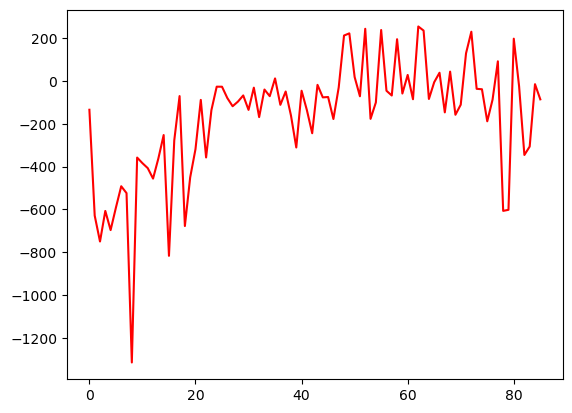

In [17]:
%matplotlib inline
plt.plot(np.arange(len(agent.scores_history)), agent.scores_history, color='r')

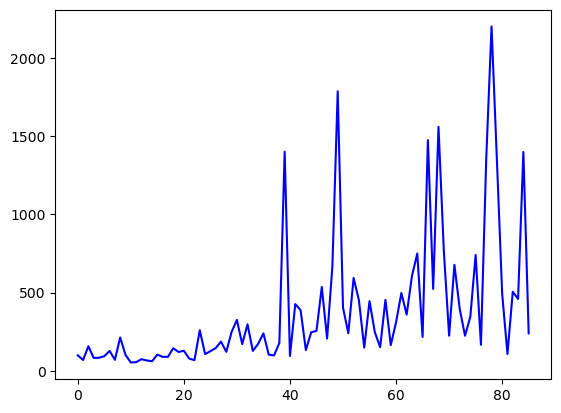

In [18]:
%matplotlib inline
plt.plot(np.arange(len(agent.steps_history)), agent.steps_history, color='b')

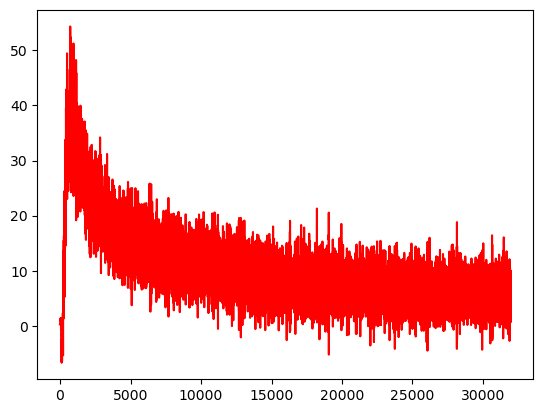

In [19]:
%matplotlib inline
plt.plot(np.arange(len(agent.ac_loss_rw)), agent.ac_loss_rw, color='r')

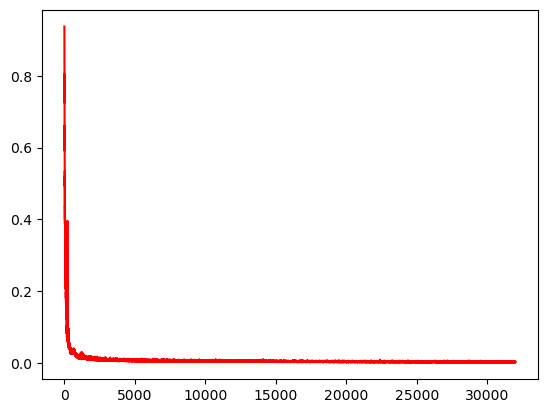

In [20]:
%matplotlib inline
plt.plot(np.arange(len(agent.ac_loss_st)), agent.ac_loss_st, color='r')

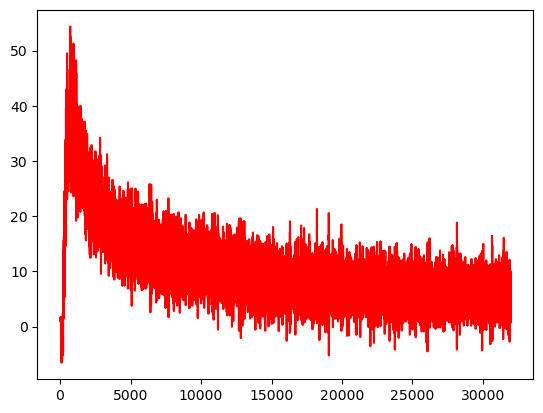

In [21]:
%matplotlib inline
plt.plot(np.arange(len(agent.ac_loss_final)), agent.ac_loss_final, color='r')

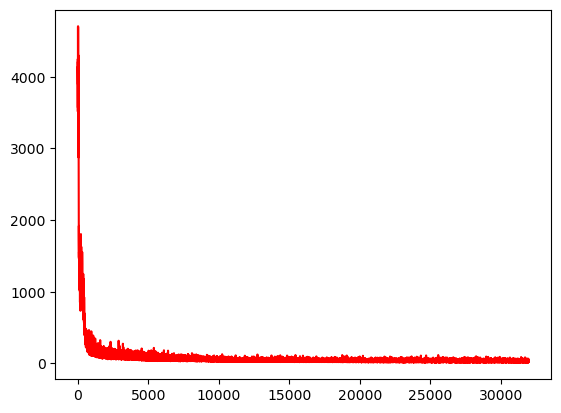

In [22]:
%matplotlib inline
plt.plot(np.arange(len(agent.ct_loss)), agent.ct_loss, color='r')

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
agent.act(env)
env.close()